In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt 
import requests
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import date
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud, STOPWORDS 

In [5]:
# Read chatlog data
chatlog = pd.read_csv('../excel/chatlog_jul.csv') 

In [33]:
chatlog.to_pickle('../data/chatlog_new.p')

In [16]:
chatlog_old = pd.read_pickle('../data/chatlog.p')

In [17]:
chatlog_old

,userId,full_name,message,role,_date,_time
0,2433413723406579,Watsana Kongngoen,สวัสดี,User,2019-11-01,15:23
1,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,15:23
2,2433413723406579,Watsana Kongngoen,"{'type': 'quick_reply', 'list_object': [{'text...",Admin,2019-11-01,15:23
3,2433413723406579,Watsana Kongngoen,สวัสดีครับ,User,2019-11-01,16:15
4,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,16:15
...,...,...,...,...,...,...
2298575,1379039449007314,None None,สาขา วังไผ่ (ชุมพร) ตรงข้ามบิ๊กซี สาขาชุมพร จ้า,User,2020-05-24,23:56
2298576,1379039449007314,None None,จริงใจพร้อมให้ความช่วยเหลือ รอสักครู่นะจ๊ะ,User,2020-05-24,23:57
2298577,1379039449007314,None None,เอกสารประกอบการยื่นเรื่อง\n1. เล่มทะเบียนรถตัว...,User,2020-05-24,23:58
2298578,1379039449007314,None None,รถปลอดภาระแล้วหรืออยู่ระหว่างผ่อนชำระคับ,User,2020-05-24,23:59


In [28]:
chatlog_old

,userId,full_name,message,role,_date,_time
0,2433413723406579,Watsana Kongngoen,สวัสดี,User,2019-11-01,15:23
1,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,15:23
2,2433413723406579,Watsana Kongngoen,"{'type': 'quick_reply', 'list_object': [{'text...",Admin,2019-11-01,15:23
3,2433413723406579,Watsana Kongngoen,สวัสดีครับ,User,2019-11-01,16:15
4,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,16:15
...,...,...,...,...,...,...
2298575,1379039449007314,None None,สาขา วังไผ่ (ชุมพร) ตรงข้ามบิ๊กซี สาขาชุมพร จ้า,User,2020-05-24,23:56
2298576,1379039449007314,None None,จริงใจพร้อมให้ความช่วยเหลือ รอสักครู่นะจ๊ะ,User,2020-05-24,23:57
2298577,1379039449007314,None None,เอกสารประกอบการยื่นเรื่อง\n1. เล่มทะเบียนรถตัว...,User,2020-05-24,23:58
2298578,1379039449007314,None None,รถปลอดภาระแล้วหรืออยู่ระหว่างผ่อนชำระคับ,User,2020-05-24,23:59


In [10]:
chatlog.astype(str)
chatlog

,userId,full_name,message,role,time,_date,_time
0,3158291677560347,กาลเวลาหมุนเวียนเปลี่ยนไป จิตใจคนก็เริ่มเปลี่ย...,DLJingjai,User,2020-07-01 10:14:22,2020-07-01,10:14
1,2341124272605948,Maxky Tangman,สอบถามยอดชำระคับ,User,2020-07-04 13:00:14,2020-07-04,13:00
2,2341124272605948,Maxky Tangman,"{'type': 'text', 'text': 'ผม ""จริงใจ"" พร้อมดูแ...",Admin,2020-07-04 13:00:18,2020-07-04,13:00
3,2341124272605948,Maxky Tangman,"{'type': 'text', 'text': 'จริงใจพร้อมให้ความช่...",Admin,2020-07-04 13:00:19,2020-07-04,13:00
4,2341124272605948,Maxky Tangman,0889285502,User,2020-07-04 15:39:57,2020-07-04,15:39
...,...,...,...,...,...,...,...
574679,2988152727923811,โนช รักนีมีจริงบัางไหม,ขอรายชื่อบริษัทประกัน2,User,2020-07-16 11:16:41,2020-07-16,11:16
574680,2988152727923811,โนช รักนีมีจริงบัางไหม,"{'type': 'text', 'text': 'เพื่อลูกค้าที่น่ารัก...",Admin,2020-07-16 11:16:44,2020-07-16,11:16
574681,2988152727923811,โนช รักนีมีจริงบัางไหม,"{'type': 'image', 'list_object': [{'original_u...",Admin,2020-07-16 11:16:44,2020-07-16,11:16
574682,2988152727923811,โนช รักนีมีจริงบัางไหม,"{'type': 'quick_reply', 'list_object': [{'text...",Admin,2020-07-16 11:16:44,2020-07-16,11:16


In [34]:
chatlog_new = pd.read_pickle('../data/chatlog_new.p')

In [35]:
chatlog_new

,userId,full_name,message,role,time,_date,_time
0,2763095730486180,Nawasorn Thippayachan,จะส่งเอกสารเปลี่ยนที่อยู่ กับเปลี่ยนชื่อน่ะค่ะ,User,2020-06-02 09:35:45,2020-06-02,09:35
1,2763095730486180,Nawasorn Thippayachan,"{'type': 'text', 'text': 'ผม ""จริงใจ"" พร้อมดูแ...",Admin,2020-06-02 09:35:47,2020-06-02,09:35
2,2763095730486180,Nawasorn Thippayachan,"{'type': 'text', 'text': 'สอบถามข้อมูลใด ลองพิ...",Admin,2020-06-02 09:35:48,2020-06-02,09:35
3,2763095730486180,Nawasorn Thippayachan,จะส่งเอกสารเปลี่ยนที่อยู่ กับเปลี่ยนชื่อน่ะค่ะ,User,2020-06-02 09:36:05,2020-06-02,09:36
4,2763095730486180,Nawasorn Thippayachan,"{'type': 'text', 'text': 'สอบถามข้อมูลใด ลองพิ...",Admin,2020-06-02 09:36:08,2020-06-02,09:36
...,...,...,...,...,...,...,...
347429,2699492556816845,Watcharapon Tharaboon,"{'type': 'carousel', 'list_object': [{'title':...",Admin,2020-06-24 16:30:18,2020-06-24,16:30
347430,2890426974399046,Momsingto Singto,NaN,User,2020-06-24 16:30:57,2020-06-24,16:30
347431,2890426974399046,Momsingto Singto,สินเชื่อทะเบียนรถยนต์1,User,2020-06-24 16:30:57,2020-06-24,16:30
347432,2890426974399046,Momsingto Singto,"{'type': 'text', 'text': 'ผม ""จริงใจ"" พร้อมดูแ...",Admin,2020-06-24 16:30:59,2020-06-24,16:30


In [4]:
def check_keywords(txt):
    if "toyotavogo" in txt:
        return 1
    else:
        return 0

In [7]:
# Format time to match with the data
today = date.today()
td = today.strftime("%Y-%m-%d")

In [8]:
one_month = today + relativedelta(months=-1)
td_minus_one_month = one_month.strftime("%Y-%m-%d")

In [9]:
# Clean the chatlog to have only user conversation on specific date
def clean_chatlog(chatlog, start_date:str=td_minus_one_month, end_date:str=td):
    df = chatlog[['userId', 'message', 'role', '_date']] 
    df = df.loc[df.role=='User']
    return df[(df._date >= start_date) & (df._date <= end_date)]

In [18]:
df_old = clean_chatlog(chatlog_old, start_date='2019-11-01', end_date='2019-11-30')
df_old

,userId,message,role,_date
0,2433413723406579,สวัสดี,User,2019-11-01
3,2433413723406579,สวัสดีครับ,User,2019-11-01
6,2433413723406579,สวัสดีจ้า,User,2019-11-04
9,2433413723406579,ไม่ต้องยุ่งอ่ะ,User,2019-11-04
11,2433413723406579,ไม่ต้องมาคุย,User,2019-11-04
...,...,...,...,...
378303,2893506850661459,1,User,2019-11-30
378308,2893506850661459,มีสาขาไหนในจังหวัดอยุธยารับพนักงานบ้างไหมค่ะ,User,2019-11-30
378313,2513727928747069,ขอข้อมูลป.ชัน1หน่อย,User,2019-11-30
378316,2513727928747069,ปะกันชันนึง,User,2019-11-30


In [11]:
chatlog.dtypes

userId        int64
full_name    object
message      object
role         object
time         object
_date        object
_time        object
dtype: object

In [12]:
df_new = clean_chatlog(chatlog, start_date='2020-07-01', end_date='2020-07-31')
df_new

,userId,message,role,_date
0,3158291677560347,DLJingjai,User,2020-07-01
1,2341124272605948,สอบถามยอดชำระคับ,User,2020-07-04
4,2341124272605948,0889285502,User,2020-07-04
5,2341124272605948,โกศล ตั้งมั่น,User,2020-07-04
6,2341124272605948,ตอนนี้ทันไหม,User,2020-07-04
...,...,...,...,...
574671,2988152727923811,ราคา ประกันภัยชั้น 1 ของไทยวิวัฒน์ครับ,User,2020-07-16
574675,2988152727923811,เริ่มต้น2,User,2020-07-16
574677,2988152727923811,รายละเอียดประกันรถยนต์2,User,2020-07-16
574679,2988152727923811,ขอรายชื่อบริษัทประกัน2,User,2020-07-16


In [40]:
df_new.dtypes

userId      int64
message    object
role       object
_date      object
dtype: object

In [13]:
df_new.groupby(['userId'])['message'].apply(lambda x: x).reset_index()

,index,message
0,0,DLJingjai
1,1,สอบถามยอดชำระคับ
2,4,0889285502
3,5,โกศล ตั้งมั่น
4,6,ตอนนี้ทันไหม
...,...,...
250028,574671,ราคา ประกันภัยชั้น 1 ของไทยวิวัฒน์ครับ
250029,574675,เริ่มต้น2
250030,574677,รายละเอียดประกันรถยนต์2
250031,574679,ขอรายชื่อบริษัทประกัน2


In [14]:
df_new['userId'] = df_new.userId.astype(str)

In [10]:
df_new

,userId,message,role,_date
0,2763095730486180,จะส่งเอกสารเปลี่ยนที่อยู่ กับเปลี่ยนชื่อน่ะค่ะ,User,2020-06-02
3,2763095730486180,จะส่งเอกสารเปลี่ยนที่อยู่ กับเปลี่ยนชื่อน่ะค่ะ,User,2020-06-02
5,2763095730486180,ขออีเมลล์หน่อยค่ะ,User,2020-06-02
7,2373618052767383,อยากกู้เพิ่มต้องทำไงครับ,User,2020-06-02
8,2373618052767383,ของผมค้างอยู่1งวดคือตามกำหนดจะหมดเดือนนี้ก็เลย...,User,2020-06-02
...,...,...,...,...
432638,3598869880130553,ขอรายล่ะเอียดและราคา\n2+\n3+\nค่ะ,User,2020-06-26
432639,3598869880130553,ถ้างั้นไม่เปนไรค่ะเดี๋ยวไปคุยรายละเอียดที่เงิน...,User,2020-06-26
432640,3598869880130553,NaN,User,2020-06-30
432641,3598869880130553,ใบขับขี่ไม่ถึง2ปี ซื้อประกัน2+ได้มั้ยค่ะ,User,2020-06-30


In [36]:
df_newer = clean_chatlog(chatlog_new, start_date='2020-06-02', end_date='2020-06-24')
df_newer

,userId,message,role,_date
0,2763095730486180,จะส่งเอกสารเปลี่ยนที่อยู่ กับเปลี่ยนชื่อน่ะค่ะ,User,2020-06-02
3,2763095730486180,จะส่งเอกสารเปลี่ยนที่อยู่ กับเปลี่ยนชื่อน่ะค่ะ,User,2020-06-02
5,2763095730486180,ขออีเมลล์หน่อยค่ะ,User,2020-06-02
7,2373618052767383,อยากกู้เพิ่มต้องทำไงครับ,User,2020-06-02
8,2373618052767383,ของผมค้างอยู่1งวดคือตามกำหนดจะหมดเดือนนี้ก็เลย...,User,2020-06-02
...,...,...,...,...
347419,2699492556816845,กู้ยังไงครับ,User,2020-06-24
347422,2699492556816845,กู้เงิน,User,2020-06-24
347424,2699492556816845,เงื่อนไขการขอสินเชื่อรถบรรทุก2,User,2020-06-24
347430,2890426974399046,NaN,User,2020-06-24


In [8]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [9]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [15]:
# Utils
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(',', ' ')
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False)
    return tokens

In [16]:
# Clean undesired text
def clean_text_1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊|คร้า','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คัฟ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [17]:
def filter_words(text):
    text = text.replace('\n', ' ') 
    text = text.replace(',', ' ')
    stop_words = set(thai_stopwords()) 
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False) 
    filtered_text = [] 
    for w in tokens: 
        if w not in stop_words: 
            filtered_text.append(w) 
    return filtered_text

In [32]:
stop_words = set(thai_stopwords())

{'เพียงเพราะ', 'คราวนี้', 'หรือยัง', 'มิ', 'อย่างๆ', 'ที่นั้น', 'จัดให้', 'พวกฉัน', 'หากแม้นว่า', 'แท้จริง', 'สั้นๆ', 'พอตัว', 'กันดีไหม', 'นี่แหละ', 'ทั้งตัว', 'มุ่ง', 'เหตุ', 'เก็บ', 'สมัยนี้', 'ตั้งแต่', 'อนึ่ง', 'นํา', 'ราย', 'ใหญ่', 'ขณะเดียวกัน', 'กระผม', 'เพียงพอ', 'ขณะที่', 'จำเป็น', 'เหตุไร', 'นับแต่ที่', 'ส่วนด้อย', 'ช้าๆ', 'เกิน', 'ลง', 'ละ', 'ค่อยไปทาง', 'พอ', 'ที่ใด', 'หมดกัน', 'พอจะ', 'ยังคง', 'พา', 'เช่นกัน', 'เรียบ', 'คุณ', 'มั้ยนะ', 'เมื่อไร', 'ทุกๆ', 'อยู่', 'แต่เดิม', 'แค่ไหน', 'จัดทำ', 'มั้ยนั่น', 'สิ่งใด', 'ก็ได้', 'เฉย', 'เปิดเผย', 'เริ่ม', 'เล็กน้อย', 'คล้าย', 'อื่นๆ', 'ว่า', 'ยก', 'ที่สุด', 'เสียนั่น', 'ทำๆ', 'เพียงไหน', 'อันเนื่องมาจาก', 'ไง', 'ยิ่งใหญ่', 'การ', 'ภายหลัง', 'ใช่ไหม', 'ดั่ง', 'ยืนยาว', 'ทีละ', 'ทำให้', 'ยิ่งขึ้น', 'ข้างบน', 'ในเมื่อ', 'ยังงั้น', 'ช้านาน', 'อันที่จริง', 'คราวหลัง', 'ก็คือ', 'ทุกสิ่ง', 'ที่ละ', 'ที่แท้', 'อย่างหนึ่ง', 'เป็นอัน', 'เฉพาะ', 'วันนั้น', 'แต่ละ', 'หากแม้น', 'ภายภาค', 'ก่อนๆ', 'ตลอดไป', 'ก็ตาม', 'เห็นจะ', 'ณ', 'รือว่า', '

In [18]:
def remove_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [19]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u200B"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [20]:
# Combine
def clean_text_full(df):
    df['userId'] = df.userId.astype(str) 
    df['message'] = df['message'].astype(str)
    df = df.groupby(['userId'])['message'].apply(lambda x: ','.join(x)).reset_index()
    df['message'] = df['message'].apply(lambda x: clean_text_1(x))
    df['message'] = df['message'].apply(lambda x: remove_emoji(x))
    df['message'] = df['message'].apply(lambda x: remove_digits(x))
    df['message'] = df['message'].apply(lambda x: filter_words(x))
    df['message'] = df['message'].apply(lambda x: " ".join(x))
    return df

In [14]:
df_old_clean = clean_text_full(df_old)
df_old_clean

NameError: name 'df_old' is not defined

In [21]:
df_new_clean = clean_text_full(df_new)
df_new_clean

,userId,message
0,1043290442441379,ช่อง ทางการ ชำระเงิน สินเชื่อ ประกัน s ช่อง ทา...
1,1059467974177980,แอด สไตล์ ชัดเจน รายละเอียด สินเชื่อ สินเชื่อ ...
2,1062404887216880,ลิ้งค์ ประกัน รถยนต์ ลิ้งค์ ประกัน รถยนต์
3,1067244353399531,ทำ บัตร เงิน กด เงิน ใด้ ตู้ บอ ติดต่อ เผ ูก บ...
4,1072525872861099,httpsscontentxxfbcdnnetvtnjpgnccatncsidbencohc...
...,...,...
26236,6745195132168772,typelegacyreplytomessageactionmessagestart tal...
26237,7105529509508698,ผม จ่าย เดือน หน้่า เดือน ผม อุบ ติ วันที่ htt...
26238,7275600865795415,nan ลิ้งค์ สินเชื่อ รถยนต์ รถจักร ยา นย นรา ย ...
26239,891336897632930,nan เบี้ย


In [51]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [52]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [15]:
# find top 20 keywords that has the highest TF-IDF average score
def top_20_keywords(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / np.count_nonzero(feat_clean_array,axis=0) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    result_clean['word'] = result_clean['word'].apply(lambda x: x.replace(" ", ""))
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [22]:
def top_20_keywords_new(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / len(df['userId']) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    result_clean['word'] = result_clean['word'].apply(lambda x: x.replace(" ", ""))
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [17]:
df_new_normal = top_20_keywords(df_new_clean)
df_new_normal 

,word,avg_tfidf
0,allnewdmax,1.0
504,คนรับสายเปลี่ยนคน,1.0
3693,รถผ่อนจำนำ,1.0
3720,รถผ่อนโอนย้าย,1.0
3728,รถฟอร์ดเฟียสต้า,1.0
3812,รถรีโว,1.0
3816,รถรุ่นจำนำ,1.0
5900,เรื่องไฟแนนซ์รถ,1.0
5887,เรื่องสมัครงานสาขา,1.0
534,คิวอาโค้ต,1.0


In [23]:
df_new_new = top_20_keywords_new(df_new_clean)
df_new_new 

,word,avg_tfidf
14265,ลิ้งค์ประกันรถยนต์,0.035605
943,nanลิ้งค์ประกัน,0.026621
13813,รายละเอียดประกันรถยนต์,0.023200
2136,typelegacyreplytomessageactionmessagestarttalk...,0.021506
18117,เบี้ยประกันรถคัน,0.021337
11863,รถคันโปรด,0.021331
15670,สินเชื่อทะเบียนรถจักรยานยนต์,0.016227
1839,talkingสไตล์ชัดเจน,0.015794
6267,ติดต่อเหs,0.015664
9001,ประกันรถยนต์s,0.015030


In [36]:
df_new_new.to_clipboard()

In [30]:
doc = "In the-state-of-art of the NLP field, Embedding is the \
success way to resolve text related problem and outperform \
Bag of Words ( BoW ). Indeed, BoW introduced limitations \
large feature dimension, sparse representation etc."
count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([doc])
count_occur_df = pd.DataFrame(
    (count, word) for word, count in
     zip(count_occurs.toarray().tolist()[0], 
    count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
count_occur_df.head()

,Word,Count
16,of,3
26,the,3
3,bow,2
0,and,1
28,way,1


In [37]:
corpus = df_new_clean['message']

0                                              วีออส ใรคั
1                                   ปผม วีโก้ แชมป์ ประตู
2                                                  ออ นิว
3       กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...
4                                                        
                              ...                        
2139                      isuzudmax sx สุรินทร์ ตรีทศ กุล
2140                                   มอ ไซ ผ่อน กู้ ไหม
2141                                         อีซูซุ d max
2142                ผม รายละเอียด อัตราดอกเบี้ย รถ มอไซค์
2143    รายละเอียด ประกัน รถยนต์ ข้อมูล ประกัน เริ่มต้...
Name: message, Length: 2144, dtype: object

In [50]:
count_vectorizer = CountVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2)

In [51]:
count_vectorizer.fit(corpus)

CountVectorizer(min_df=2, ngram_range=(3, 3), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1c9805560>)

In [52]:
feat_count = count_vectorizer.transform(corpus)

In [53]:
feat_count_array = feat_count.toarray()

In [54]:
count_occurs_df = pd.DataFrame()

In [56]:
count_occur_df['word'] = count_vectorizer.get_feature_names()
count_occur_df['occurences'] = feat_count_array.sum(axis=0)

ValueError: Length of values does not match length of index

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
def count_words_use(df):
    count_vec = CountVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2)
    count_occurs = count_vec.fit_transform(df['message'])
    count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))
    count_occur_df.columns = ['Word', 'Count']
    return count_occur_df.sort_values('Count', ascending=False, inplace=True)

In [35]:
df_new_count = count_words_use(df_new_clean)
print(df_new_count)

None


In [24]:
def gen_text_for_wordcloud(df):
    words = df['word']
    words_to_array = words.tolist()
    return (" ".join(words_to_array))

In [25]:
text = gen_text_for_wordcloud(df_new_new)
print(text)

ลิ้งค์ประกันรถยนต์ nanลิ้งค์ประกัน รายละเอียดประกันรถยนต์ typelegacyreplytomessageactionmessagestarttalkingสไตล์ เบี้ยประกันรถคัน รถคันโปรด สินเชื่อทะเบียนรถจักรยานยนต์ talkingสไตล์ชัดเจน ติดต่อเหs ประกันรถยนต์s เงื่อนไขสินเชื่อรถจักรยานยนต์ nanลิ้งค์สินเชื่อ ลิ้งค์สินเชื่อรถยนต์ รถยนต์เบี้ยประกันรถ รถจักรยานยนต์เงื่อนไขสินเชื่อ รายละเอียดสินเชื่อสินเชื่อ ประกันรถยนต์เบี้ยประกัน สไตล์ชัดเจนรายละเอียด ทะเบียนรถจักรยานยนต์เงื่อนไข รถจักรยานยนต์ติดต่อเห


In [28]:
def gen_word_cloud(text):
    path = './font/THSarabunNew.ttf'
    wordcloud = WordCloud(font_path=path, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap='coolwarm',regexp = r"[ก-๙a-zA-Z']+", random_state=1).generate(text) 
    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig('../WordCloud/keyword_2020-07.png')

#     plt.savefig('./WordCloud/keyword_{}.png'.format(td))
    

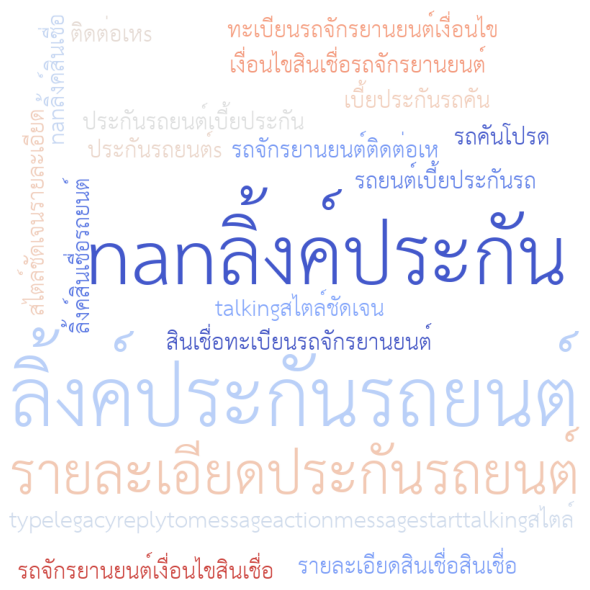

In [29]:
gen_word_cloud(text)

In [30]:
def post_picture(filename:str, filepath:str):

    url = "https://api.botnoigroup.com/upload_images"

    payload = {
        'bot_id': '5db6a992b5162fcd709d76d6',
        'before_url': ''
        }

    files =  {'file':(filename, open(filepath, 'rb'), "multipart/form-data")}

    getdata = requests.post(url, data=payload, files=files)
    
    # Get image url
    api_response_text = getdata.text.split()
    response = api_response_text[2].replace("\"", "")
    response_url = response.replace(",", "")
    return response_url

In [34]:
# wc_location = post_picture('keyword_2020-05.png', '/Users/phrare/NTL_dashboard/WordCloud/keyword_2020-05.png')
wc_location = post_picture('keyword_2020-07.png','/Users/phrare/NTL_dashboard/WordCloud/keyword_2020-07.png')
final_df = pd.DataFrame([[td.replace("-", ""), '-', '0', wc_location, '1']],columns=['date', 'word', 'avg_tfidf', 'location', 'pic'])

In [35]:
final_df.to_clipboard()

In [33]:
post_picture('keyword_2020-07.png','/Users/phrare/NTL_dashboard/WordCloud/keyword_2020-07.png')

'https://sme-botengine-pics.s3.amazonaws.com:443/bot_avatar_image/5db6a992b5162fcd709d76d6/044c1a52-f23b-40a3-b280-b9a306e478cf.png'